### div2 interpolation 비교

/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
JDINet interp (psnr, ssim)
    mean : (32.08 +- 0.582, 0.91 +- 0.004)
EMA-VFI ours-small interp (psnr, ssim)
    mean : (38.59 +- 1.859, 0.95 +- 0.004)
EMA-VFI ours interp (psnr, ssim)
    mean : (39.59 +- 1.738, 0.95 +- 0.004)


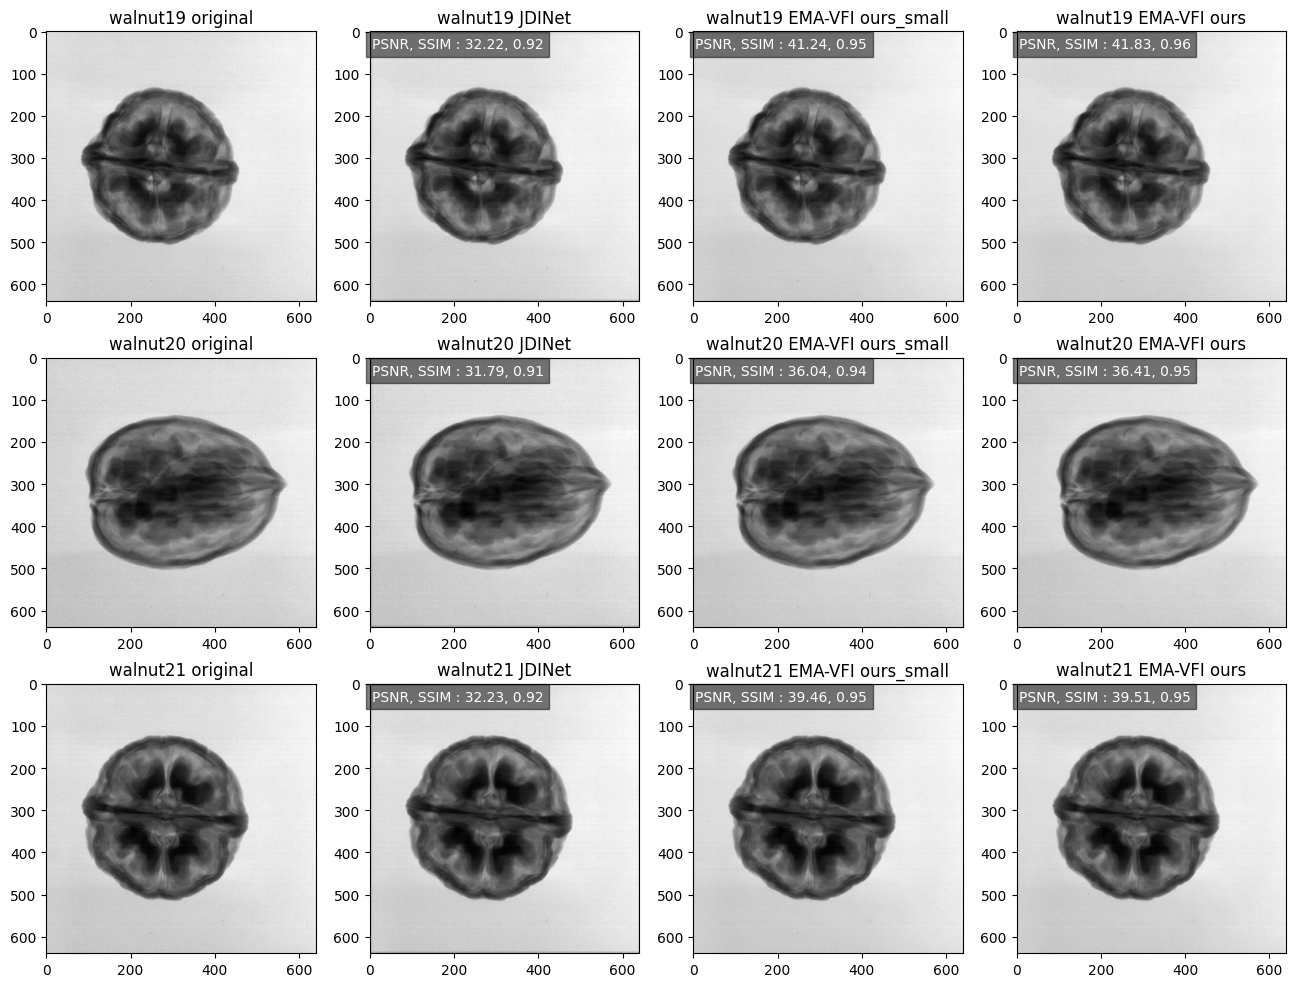

In [2]:
%cd /home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
%pwd

import matplotlib.pyplot as plt
import imageio.v2 as iio
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from math import exp
import torch
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0).cuda()
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def compute_ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Grayscale 이미지 처리 (H, W) → (1, H, W)
    if img1.ndim == 2:  
        img1 = img1[..., np.newaxis]  # (H, W) → (H, W, 1)
        img2 = img2[..., np.newaxis]
    img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)

    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)
    
    # mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    # mu2 = F.conv2d(img2, window, padding=padd, groups=channel)
    mu1 = F.conv2d(F.pad(img1, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)
    mu2 = F.conv2d(F.pad(img2, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    # sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    # sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    # sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    sigma1_sq = F.conv2d(F.pad(img1 * img1, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(F.pad(img2 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(F.pad(img1 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret

# def compute_psnr(img1, img2, max_val=1.0):
#   # PSNR 계산
#   return psnr(img1, img2, data_range=max_val)
def compute_psnr(normal_dose_slice, interp_slice):
    # Grayscale 이미지 처리 (H, W) → (1, H, W)
    if normal_dose_slice.ndim == 2:  
        normal_dose_slice = normal_dose_slice[..., np.newaxis]  # (H, W) → (H, W, 1)
        interp_slice = interp_slice[..., np.newaxis]
    normal_dose_slice = torch.from_numpy(normal_dose_slice).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    interp_slice = torch.from_numpy(interp_slice).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    diff = (normal_dose_slice - interp_slice).pow(2).mean() + 1e-8
    return -10 * math.log10(diff)

def img_normal(img):
    return ((img - img.min()) / (img.max() - img.min())).astype(np.float32)

###############################################

# ssim, psnr 평균 비교

###############################################

num_list = list(range(2, 501, 2))
img2_ssim = []
img2_psnr = []
img3_ssim = []
img3_psnr = []
img4_ssim = []
img4_psnr = []

data_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/jdinet_walnut19_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_small_walnut19_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_walnut19_div2_interpolation"
for num in num_list:
  file_name = f"scan_{num:06d}.tif"
  img1 = iio.imread(os.path.join(data_folder_path, file_name))
  img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
  img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))

  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)

  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))

data_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/walnut20_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/jdinet_walnut20_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_small_walnut20_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_walnut20_div2_interpolation"
for num in num_list:
  file_name = f"scan_{num:06d}.tif"
  img1 = iio.imread(os.path.join(data_folder_path, file_name))
  img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
  img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))

  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)

  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))

data_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/jdinet_walnut21_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_small_walnut21_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_walnut21_div2_interpolation"
for num in num_list:
  file_name = f"scan_{num:06d}.tif"
  img1 = iio.imread(os.path.join(data_folder_path, file_name))
  img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
  img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))

  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)

  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))

print(f"JDINet interp (psnr, ssim)")
print(f"    mean : ({np.mean(img2_psnr):0.2f} +- {np.std(img2_psnr):0.3f}, {np.mean(img2_ssim):0.2f} +- {np.std(img2_ssim):0.3f})")
print(f"EMA-VFI ours-small interp (psnr, ssim)")
print(f"    mean : ({np.mean(img3_psnr):0.2f} +- {np.std(img3_psnr):0.3f}, {np.mean(img3_ssim):0.2f} +- {np.std(img3_ssim):0.3f})")
print(f"EMA-VFI ours interp (psnr, ssim)")
print(f"    mean : ({np.mean(img4_psnr):0.2f} +- {np.std(img4_psnr):0.3f}, {np.mean(img4_ssim):0.2f} +- {np.std(img4_ssim):0.3f})")


###############################################

# ssim, psnr 단일 비교

###############################################


# div2_interp_fdk의 짝수 넘버가 보간된 데이터 입니다.
file_name = "scan_000100.tif"
font = 10

fig, ax = plt.subplots(3, 4, figsize=(16, 12))

data_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/jdinet_walnut19_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_small_walnut19_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_walnut19_div2_interpolation"
img1 = iio.imread(os.path.join(data_folder_path, file_name))
img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))
img1_normal = img_normal(img1)
img2_normal = img_normal(img2)
img3_normal = img_normal(img3)
img4_normal = img_normal(img4)

ax[0][0].imshow(img1, cmap='gray')
ax[0][0].set_title("walnut19 original")

ax[0][1].imshow(img2, cmap='gray')
ax[0][1].set_title("walnut19 JDINet")
ax[0][1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img2_normal):.2f}, {compute_ssim(img1_normal, img2_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[0][2].imshow(img3, cmap='gray')
ax[0][2].set_title("walnut19 EMA-VFI ours_small")
ax[0][2].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img3_normal):.2f}, {compute_ssim(img1_normal, img3_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[0][3].imshow(img3, cmap='gray')
ax[0][3].set_title("walnut19 EMA-VFI ours")
ax[0][3].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img4_normal):.2f}, {compute_ssim(img1_normal, img4_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

data_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/walnut20_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/jdinet_walnut20_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_small_walnut20_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_walnut20_div2_interpolation"
img1 = iio.imread(os.path.join(data_folder_path, file_name))
img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))
img1_normal = img_normal(img1)
img2_normal = img_normal(img2)
img3_normal = img_normal(img3)
img4_normal = img_normal(img4)

ax[1][0].imshow(img1, cmap='gray')
ax[1][0].set_title("walnut20 original")

ax[1][1].imshow(img2, cmap='gray')
ax[1][1].set_title("walnut20 JDINet")
ax[1][1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img2_normal):.2f}, {compute_ssim(img1_normal, img2_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[1][2].imshow(img3, cmap='gray')
ax[1][2].set_title("walnut20 EMA-VFI ours_small")
ax[1][2].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img3_normal):.2f}, {compute_ssim(img1_normal, img3_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[1][3].imshow(img3, cmap='gray')
ax[1][3].set_title("walnut20 EMA-VFI ours")
ax[1][3].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img4_normal):.2f}, {compute_ssim(img1_normal, img4_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))


data_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div1"
jdinet_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/jdinet_walnut21_div2_interpolation"
emavfi_ours_small_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_small_walnut21_div2_interpolation"
emavfi_ours_interp_folder_path = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_walnut21_div2_interpolation"
img1 = iio.imread(os.path.join(data_folder_path, file_name))
img2 = iio.imread(os.path.join(jdinet_interp_folder_path, file_name))
img3 = iio.imread(os.path.join(emavfi_ours_small_interp_folder_path, file_name))
img4 = iio.imread(os.path.join(emavfi_ours_interp_folder_path, file_name))
img1_normal = img_normal(img1)
img2_normal = img_normal(img2)
img3_normal = img_normal(img3)
img4_normal = img_normal(img4)

ax[2][0].imshow(img1, cmap='gray')
ax[2][0].set_title("walnut21 original")

ax[2][1].imshow(img2, cmap='gray')
ax[2][1].set_title("walnut21 JDINet")
ax[2][1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img2_normal):.2f}, {compute_ssim(img1_normal, img2_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[2][2].imshow(img3, cmap='gray')
ax[2][2].set_title("walnut21 EMA-VFI ours_small")
ax[2][2].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img3_normal):.2f}, {compute_ssim(img1_normal, img3_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[2][3].imshow(img3, cmap='gray')
ax[2][3].set_title("walnut21 EMA-VFI ours")
ax[2][3].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img4_normal):.2f}, {compute_ssim(img1_normal, img4_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

plt.show()

### fdk 결과물 비교

/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
sparse 1/2 (psnr, ssim)
    mean : (30.12 +- 2.200, 0.83 +- 0.028)
JDINet (psnr, ssim)
    mean : (32.53 +- 3.206, 0.89 +- 0.022)
EMA-VFI ours_small (psnr, ssim)
    mean : (34.30 +- 2.551, 0.90 +- 0.019)
EMA-VFI ours (psnr, ssim)
    mean : (34.85 +- 2.401, 0.91 +- 0.017)


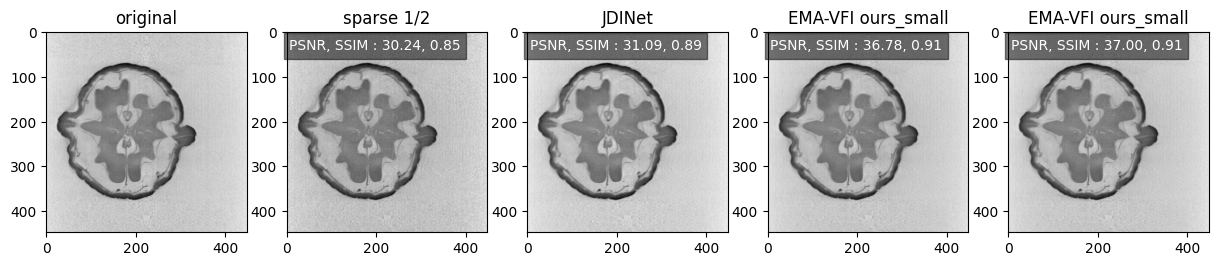

In [4]:
%cd /home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
%pwd

import matplotlib.pyplot as plt
import imageio.v2 as iio
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from math import exp
import torch
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0).cuda()
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def compute_ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Grayscale 이미지 처리 (H, W) → (1, H, W)
    if img1.ndim == 2:  
        img1 = img1[..., np.newaxis]  # (H, W) → (H, W, 1)
        img2 = img2[..., np.newaxis]
    img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)

    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)
    
    # mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    # mu2 = F.conv2d(img2, window, padding=padd, groups=channel)
    mu1 = F.conv2d(F.pad(img1, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)
    mu2 = F.conv2d(F.pad(img2, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    # sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    # sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    # sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    sigma1_sq = F.conv2d(F.pad(img1 * img1, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(F.pad(img2 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(F.pad(img1 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret

# def compute_psnr(img1, img2, max_val=1.0):
#   # PSNR 계산
#   return psnr(img1, img2, data_range=max_val)
def compute_psnr(normal_dose_slice, interp_slice):
    # Grayscale 이미지 처리 (H, W) → (1, H, W)
    if normal_dose_slice.ndim == 2:  
        normal_dose_slice = normal_dose_slice[..., np.newaxis]  # (H, W) → (H, W, 1)
        interp_slice = interp_slice[..., np.newaxis]
    normal_dose_slice = torch.from_numpy(normal_dose_slice).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    interp_slice = torch.from_numpy(interp_slice).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    diff = (normal_dose_slice - interp_slice).pow(2).mean() + 1e-8
    return -10 * math.log10(diff)

def img_normal(img):
    return ((img - img.min()) / (img.max() - img.min())).astype(np.float32)

num_list = list(range(1,201))
img2_ssim = []
img2_psnr = []
img3_ssim = []
img3_psnr = []
img4_ssim = []
img4_psnr = []
img5_ssim = []
img5_psnr = []


origin_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div1_fdk"
origin_div2_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div2_fdk"
jdinet_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/jdinet_walnut19_div2_interpolation_fdk"
emavfi_ours_small_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_small_walnut19_div2_interpolation_fdk"
emavfi_ours_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_walnut19_div2_interpolation_fdk"
for num in num_list:
  file_name = f"fdk_{num:06d}.png"
  img1 = iio.imread(os.path.join(origin_fdk, file_name))
  img2 = iio.imread(os.path.join(origin_div2_fdk, file_name))
  img3 = iio.imread(os.path.join(jdinet_div2_interp_fdk, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_small_div2_interp_fdk, file_name))
  img5 = iio.imread(os.path.join(emavfi_ours_div2_interp_fdk, file_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))

origin_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/walnut20_div1_fdk"
origin_div2_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/walnut20_div2_fdk"
jdinet_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/jdinet_walnut20_div2_interpolation_fdk"
emavfi_ours_small_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_small_walnut20_div2_interpolation_fdk"
emavfi_ours_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/emavfi_ours_walnut20_div2_interpolation_fdk"
for num in num_list:
  file_name = f"fdk_{num:06d}.png"
  img1 = iio.imread(os.path.join(origin_fdk, file_name))
  img2 = iio.imread(os.path.join(origin_div2_fdk, file_name))
  img3 = iio.imread(os.path.join(jdinet_div2_interp_fdk, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_small_div2_interp_fdk, file_name))
  img5 = iio.imread(os.path.join(emavfi_ours_div2_interp_fdk, file_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))


origin_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div1_fdk"
origin_div2_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div2_fdk"
jdinet_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/jdinet_walnut21_div2_interpolation_fdk"
emavfi_ours_small_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_small_walnut21_div2_interpolation_fdk"
emavfi_ours_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/emavfi_ours_walnut21_div2_interpolation_fdk"
for num in num_list:
  file_name = f"fdk_{num:06d}.png"
  img1 = iio.imread(os.path.join(origin_fdk, file_name))
  img2 = iio.imread(os.path.join(origin_div2_fdk, file_name))
  img3 = iio.imread(os.path.join(jdinet_div2_interp_fdk, file_name))
  img4 = iio.imread(os.path.join(emavfi_ours_small_div2_interp_fdk, file_name))
  img5 = iio.imread(os.path.join(emavfi_ours_div2_interp_fdk, file_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))
  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))


print(f"sparse 1/2 (psnr, ssim)")
print(f"    mean : ({np.mean(img2_psnr):0.2f} +- {np.std(img2_psnr):0.3f}, {np.mean(img2_ssim):0.2f} +- {np.std(img2_ssim):0.3f})")
print(f"JDINet (psnr, ssim)")
print(f"    mean : ({np.mean(img3_psnr):0.2f} +- {np.std(img3_psnr):0.3f}, {np.mean(img3_ssim):0.2f} +- {np.std(img3_ssim):0.3f})")
print(f"EMA-VFI ours_small (psnr, ssim)")
print(f"    mean : ({np.mean(img4_psnr):0.2f} +- {np.std(img4_psnr):0.3f}, {np.mean(img4_ssim):0.2f} +- {np.std(img4_ssim):0.3f})")
print(f"EMA-VFI ours (psnr, ssim)")
print(f"    mean : ({np.mean(img5_psnr):0.2f} +- {np.std(img5_psnr):0.3f}, {np.mean(img5_ssim):0.2f} +- {np.std(img5_ssim):0.3f})")



file_name = f"fdk_{57:06d}.png"
fig, ax = plt.subplots(1, 5, figsize=(15, 9))
font = 10

origin_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div1_fdk"
origin_div2_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div2_fdk"
jdinet_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/jdinet_walnut19_div2_interpolation_fdk"
emavfi_ours_small_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_small_walnut19_div2_interpolation_fdk"
emavfi_ours_div2_interp_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/emavfi_ours_walnut19_div2_interpolation_fdk"
img1 = iio.imread(os.path.join(origin_fdk, file_name))
img2 = iio.imread(os.path.join(origin_div2_fdk, file_name))
img3 = iio.imread(os.path.join(jdinet_div2_interp_fdk, file_name))
img4 = iio.imread(os.path.join(emavfi_ours_small_div2_interp_fdk, file_name))
img5 = iio.imread(os.path.join(emavfi_ours_div2_interp_fdk, file_name))
img1_normal = img_normal(img1)
img2_normal = img_normal(img2)
img3_normal = img_normal(img3)
img4_normal = img_normal(img4)
img5_normal = img_normal(img5)

ax[0].imshow(img1, cmap='gray')
ax[0].set_title("original")

ax[1].imshow(img2, cmap='gray')
ax[1].set_title("sparse 1/2")
ax[1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img2_normal):.2f}, {compute_ssim(img1_normal, img2_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[2].imshow(img3, cmap='gray')
ax[2].set_title("JDINet")
ax[2].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img3_normal):.2f}, {compute_ssim(img1_normal, img3_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[3].imshow(img4, cmap='gray')
ax[3].set_title("EMA-VFI ours_small")
ax[3].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img4_normal):.2f}, {compute_ssim(img1_normal, img4_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[4].imshow(img4, cmap='gray')
ax[4].set_title("EMA-VFI ours_small")
ax[4].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img5_normal):.2f}, {compute_ssim(img1_normal, img5_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))


plt.show()